# Ajuste por cuadrados mínimos
Víctor A. Bettachini, bettachini@df.uba.ar, 190921

In [1]:
import numpy as np
import pandas as pd
import scipy.optimize as opt
import matplotlib.pyplot as plt
from IPython.display import Math

## Oscilador armónico sin amortiguamiento

In [2]:
# importa salida del motiondaq del sensor de fuerza y de posición
datos= pd.read_csv('./no_amortiguado.csv', delimiter='\t', skiprows=3, decimal=',') # ignora el encabezado de 3 lineas
datos

time       (N)  Velocity 2
0     0.000000  3.842290    0.608009
1     0.016667  3.908841    0.606906
2     0.033333  3.962716    0.607876
3     0.050000  4.026098    0.603932
4     0.066667  4.073635    0.605270
..         ...       ...         ...
596   9.933333  3.423967    0.612946
597   9.950000  3.442982    0.612985
598   9.966667  3.446151    0.613157
599   9.983333  3.481011    0.615661
600  10.000000  3.506364    0.613244

[601 rows x 3 columns]

In [3]:
# Cambio el nómbre de las columnas
columnas = ['t [s]', 'F [N]', '$\Delta$x [m]']
datos.columns= columnas
datos

t [s]     F [N]  $\Delta$x [m]
0     0.000000  3.842290       0.608009
1     0.016667  3.908841       0.606906
2     0.033333  3.962716       0.607876
3     0.050000  4.026098       0.603932
4     0.066667  4.073635       0.605270
..         ...       ...            ...
596   9.933333  3.423967       0.612946
597   9.950000  3.442982       0.612985
598   9.966667  3.446151       0.613157
599   9.983333  3.481011       0.615661
600  10.000000  3.506364       0.613244

[601 rows x 3 columns]

## Grafico de mediciones

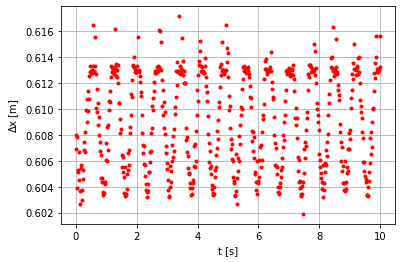

In [4]:
# grafico fuerza vs tiempo para verificar importación
fig,ax = plt.subplots()
ax.set_xlabel('t [s]')
ax.set_ylabel('$\Delta$x [m]')
ax.grid()
ax.plot(datos['t [s]'], datos['$\Delta$x [m]'], '.r')
plt.show()

Que se vé horripilante, mejor trabajamos con lo registrado por el sensor de fuerza.

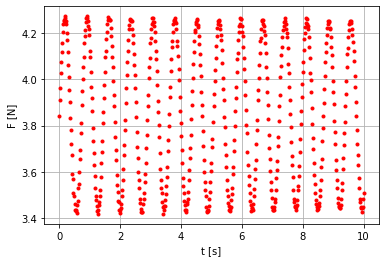

In [5]:
# grafico fuerza vs tiempo para verificar importación
fig,ax = plt.subplots()
ax.set_xlabel('t [s]')
ax.set_ylabel('F [N]')
ax.grid()
ax.plot(datos['t [s]'], datos['F [N]'], '.r')
plt.show()

La relación entre el deplazamiento desde la posición de equilibrio $\psi$ y la fuerza es simple:
$$
\psi = A \cos{(\omega t + \phi)}+ \psi_0 \\
F = m \ddot{\psi}= -A \omega^2 \cos{(\omega t + \phi)}+ F_0
$$

In [6]:
# defino las funciones a ajustar a los datos
def senoidal(t, A, omega, phi, base):
    return A* np.sin(omega*t+ phi)+ base

def cosenoidal(t, A, omega, phi, base):
    return A* np.cos(omega*t+ phi)+ base

def Fcos(t, A, omega, phi, F0):
    return -A* omega**2* np.cos(omega*t+ phi)+ F0

In [7]:
# parámetros iniciales, ayudan a una rápida convergencia
A0 = 0.8
T0=  0.7 # [s]
omega0= 2* np.pi/T0
phi0= 80* (np.pi/180)
psi0 = 0.61
F0= 3.84

In [8]:
# posición: optimización por cuadrados mínimos
parametrosIniciales= [A0, omega0, phi0, psi0]
parametrosOptimizados, parametrosCovarianza = opt.curve_fit(f= cosenoidal, xdata= datos['t [s]'], ydata= datos['F [N]'] , p0= parametrosIniciales)

In [9]:
# fuerza: optimización por cuadrados mínimos
pFiniciales= [A0, omega0, phi0, F0]
pFoptimizados, pFcovarianza = opt.curve_fit(f= Fcos, xdata= datos['t [s]'], ydata= datos['F [N]'] , p0= pFiniciales)

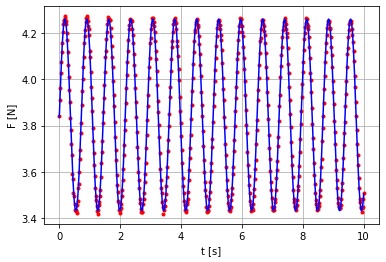

In [10]:
# graficar el ajuste superpuesto a datos permite verificar el mismo
fig,ax = plt.subplots()
ax.set_xlabel('t [s]')
ax.set_ylabel('F [N]')
ax.grid()
ax.plot(datos['t [s]'], datos['F [N]'], '.r')
ax.plot(datos['t [s]'], Fcos(datos['t [s]'], *pFoptimizados), '-b') # El * "abre" el array
plt.show()

In [11]:
# presento los parámetros optimizados
erroresPF =  np.sqrt(pFcovarianza.diagonal()) # desvio estándar es la raiz de la varianza
resF = pd.DataFrame({'valor':pFoptimizados, 'error':erroresPF}, index= ['A', '$\omega$', '$\phi$', '$F_0$'])
resF

valor     error
A         0.005482  0.000006
$\omega$  8.701499  0.000372
$\phi$    1.548623  0.002136
$F_0$     3.846105  0.000314

# Amortiguado

Si el amortiguamiento es débil, $\frac{\Gamma}{2} < \omega$, siendo $\Gamma= \frac{c}{m}$ y $c$ la constante de proporcionalidad de la fuerza de rozamiento con la velocidad $\dot{\psi}$, entonces subsiste el comportamiento oscilatorio, 
$\omega'= i \sqrt{\left| \left(\frac{\Gamma}{2}\right)^2- \omega^2 \right|}$
y la dinámica responde a 
$$
\begin{align}
\psi(t) &= A_1 \mathrm{e}^{- \frac{\Gamma}{2} t} \cos{|\omega'| t}+ A_2  \mathrm{e}^{- \frac{\Gamma}{2} t} \sin{|\omega'| t} \\
& = A \mathrm{e}^{- \frac{\Gamma}{2} t} \cos{ \left( |\omega'| t + \varphi \right) }\\
F(t) &= A \mathrm{e}^{- \frac{\Gamma}{2} t} \left[ \left( \left(\frac{\Gamma}{2}\right)^2- \omega^2 \right)  \cos{ \left( |\omega'| t + \varphi \right) } + \frac{\Gamma}{2} |\omega'| \sin{ \left( |\omega'| t + \varphi \right) } \right].
\end{align}
$$.

- Busco generar datos artifiales de amortiguamiento modificando con $\mathrm{e}^{\frac{\Gamma}{2} t}$ los datos para el no amortigüado.

In [12]:
datos['t [s]']

0       0.000000
1       0.016667
2       0.033333
3       0.050000
4       0.066667
         ...    
596     9.933333
597     9.950000
598     9.966667
599     9.983333
600    10.000000
Name: t [s], Length: 601, dtype: float64

In [13]:
Gamma = 1E-1 # [s m^-1] pues ajusto a sensor de fuerza
# c= 1E-1 # [N kg s m^-1]
# m= 150E-2 # [kg]
# Gamma = c/m
amortiguado = pd.DataFrame(columns= ['t [s]', 'F [N]'])
amortiguado['t [s]']= datos['t [s]']
amortiguado['F [N]']= (datos['F [N]']- resF['valor']['$F_0$']) * np.exp(- (Gamma/2)* datos['t [s]']) + resF['valor']['$F_0$']
amortiguado

t [s]     F [N]
0     0.000000  3.842290
1     0.016667  3.908789
2     0.033333  3.962522
3     0.050000  4.025649
4     0.066667  4.072878
..         ...       ...
596   9.933333  3.589211
597   9.950000  3.600987
598   9.966667  3.603116
599   9.983333  3.624480
600  10.000000  3.640042

[601 rows x 2 columns]

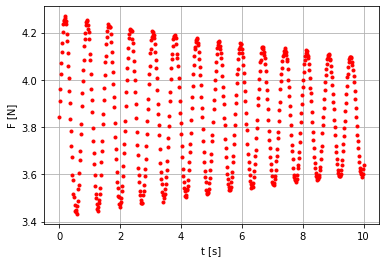

In [14]:
# grafico amortiguado
fig,ax = plt.subplots()
ax.set_xlabel('t [s]')
ax.set_ylabel('F [N]')
ax.grid()
ax.plot(amortiguado['t [s]'], amortiguado['F [N]'], '.r')
plt.show()

Tengo que guardar un csv con los datos amortiguados.

In [15]:
amortiguado.to_csv('amortiguado.csv')

In [16]:
amortiguado= pd.read_csv('amortiguado.csv')

In [17]:
# defino la función a la que ajustaré
def Famortiguado(t, Gamma, A, omega, phi, F0):
    return A* np.exp((-Gamma/2)* t)* (\
                                      ((-Gamma/2)**2 - omega**2)* np.cos(omega* t+ phi) +\
                                      (Gamma* omega/2)* np.sin(omega* t+ phi) \
                                     ) + F0

In [18]:
# parámetros iniciales, ayudan a una rápida convergencia
A0 = 0.8
T0=  0.7 # [s]
omega0= 2* np.pi/T0
phi0= 0
base0= 3.84
Gamma0 = 1E-2
parInicFAmort= [Gamma0, A0, omega0, phi0, base0]
# la optimización por cuadrados mínimos
parOptFAmort, parOptFAmortCov = opt.curve_fit(f= Famortiguado, xdata= amortiguado['t [s]'], ydata= amortiguado['F [N]'] , p0= parInicFAmort)

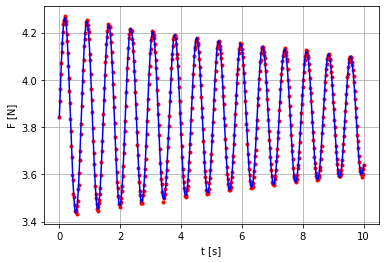

In [23]:
# graficar el ajuste superpuesto a datos permite verificar el mismo
fig,ax = plt.subplots()
ax.set_xlabel('t [s]')
ax.set_ylabel('F [N]')
ax.grid()
ax.plot(amortiguado['t [s]'], amortiguado['F [N]'], '.r')
ax.plot(amortiguado['t [s]'], Famortiguado(amortiguado['t [s]'], *parOptFAmort), '-b') # El * "abre" el array
# plt.savefig('ajusteAmortiguado.png')
plt.show()

In [20]:
plt.savefig('ajusteAmortiguado.png')

<Figure size 432x288 with 0 Axes>

In [21]:
# presento los parámetros optimizados
parOptFAmortErr =  np.sqrt(parOptFAmortCov.diagonal()) # desvio estándar es la raiz de la varianza
resFAmort = pd.DataFrame({'valor':parOptFAmort, 'error':parOptFAmortErr}, index= ['$\Gamma$', 'A', '$\omega$', '$\phi$', 'base'])
resFAmort

valor     error
$\Gamma$  0.106099  0.000725
A         0.005567  0.000010
$\omega$  8.701413  0.000366
$\phi$    1.542823  0.001817
base      3.846172  0.000240